In [36]:
from models import *
from data import DataMoudle
from main import HYPERPARAMS
from matplotlib import pyplot as plt
import math

dataset = DataMoudle(**HYPERPARAMS['dataset'])
x, y = dataset.dataset[0]
print(dataset.positive_data.step_list)

x = x.unsqueeze(0)
murenn = MuReNN(**HYPERPARAMS['model'])
murenn(x)

conv1d = Conv1D(**HYPERPARAMS['model'])
conv1d(x)

wavenet = WaveNet(**HYPERPARAMS['model'])
wavenet(x)

class Downsampling(torch.nn.Module):
    """
    Downsample the input signal by a factor of 2**J_phi.
    --------------------
    Args:
        J_phi (int): Number of levels of downsampling.
    """
    def __init__(self, J_phi):
        super().__init__()
        self.J_phi = J_phi
        # We are using a 13-tap low-pass filter
        self.phi = murenn.DTCWT(
            J=1,
            level1="near_sym_b",
            skip_hps=True,
        )


    def forward(self, x):
        for j in range(self.J_phi):
            x, _ = self.phi(x)
            x = x[:,:,::2]
        return x

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7

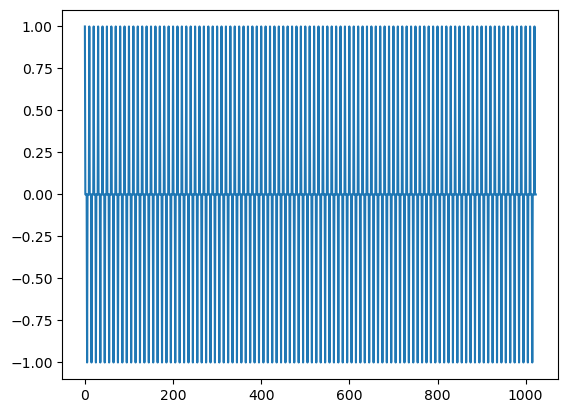

In [37]:
d = dataset.dataset
x, y = d[250]
plt.plot(x[0].numpy())

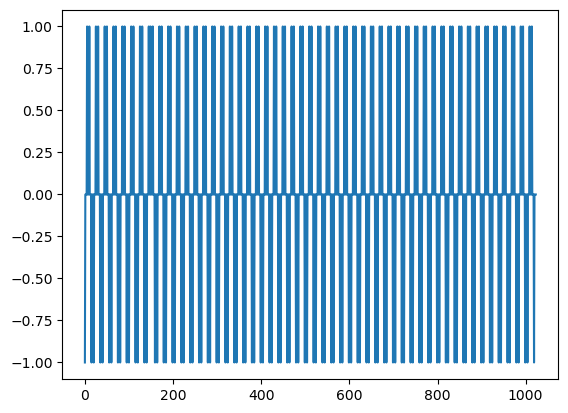

In [38]:
d = dataset.dataset
x, y = d[750]
plt.plot(x[0].numpy())

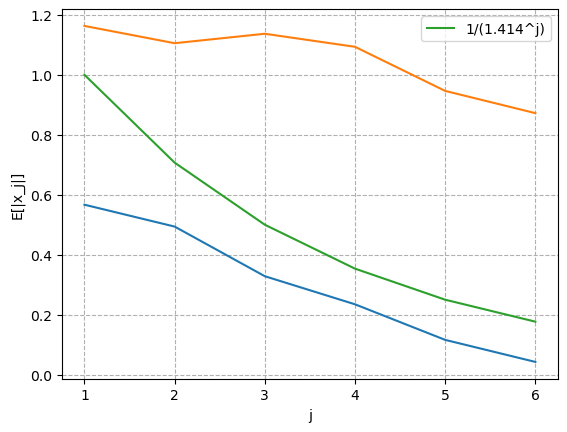

In [58]:
import murenn
import numpy as np

d = dataset.dataset
data = []
for x, y in d:
    data.append(x)
data = torch.stack(data,dim=0)
wt = murenn.DTCWT(J=6, alternate_gh=False, normalize=False)
_, hps = wt(data)
insnorm = torch.nn.InstanceNorm1d(1)

Ejs = []
Ejs_norm = []
for j, hp in enumerate(hps):
    real = insnorm(hp.real)
    imag = insnorm(hp.imag)
    hp_norm = torch.complex(real, imag)
    down = Downsampling(5-j)
    hp = down(hp.abs())
    hp_norm = down(hp_norm.abs())
    # hp = insnorm(torch.cat([hp.real, hp.imag], dim=0))
    # Ejs.append(torch.linalg.norm(hp, dim=-1).mean()/hp.shape[-1])
    Ejs.append((hp.abs()).mean())
    Ejs_norm.append((hp_norm.abs()).mean())

plt.plot(range(1,7), np.asarray(Ejs))
plt.plot(range(1,7), np.asarray(Ejs_norm))
# plt.plot(range(1,7), np.asarray(Ejs2), label='spacing={8~16}')
plt.plot(range(1,7),[1/(1.414**j) for j in range(6)], label='1/(1.414^j)')
plt.xlabel('j')
plt.ylabel('E[|x_j|]')
plt.grid(linestyle='--',which='both')
# plt.title(r"subset with spacing = {1,2}")
plt.legend()

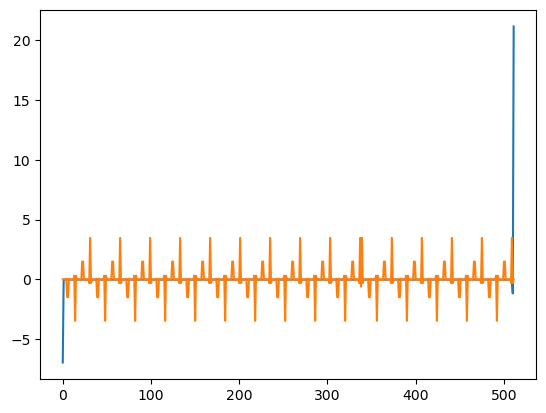

In [40]:
plt.plot(insnorm(hps[0][1].imag.view(1,1,-1)).squeeze().detach().numpy())
plt.plot(insnorm(hps[0][-1].imag.view(1,1,-1)).squeeze().detach().numpy())

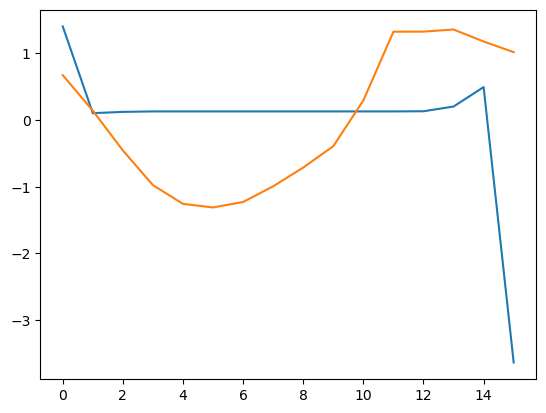

In [41]:
plt.plot(insnorm(hps[-1][1].real.view(1,1,-1)).squeeze().detach().numpy())
plt.plot(insnorm(hps[-1][-1].real.view(1,1,-1)).squeeze().detach().numpy())

Text(0.5, 1.0, 'the sine wave dataset')

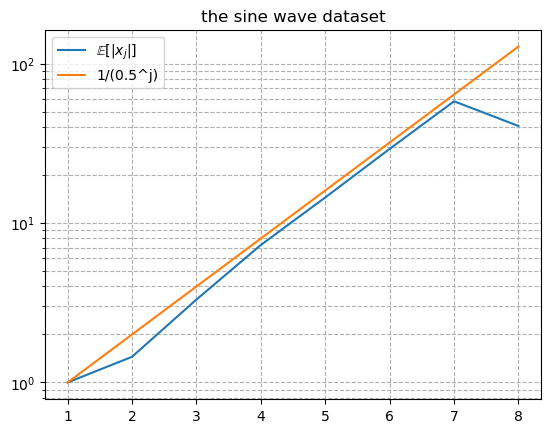

In [42]:
def generate_random_sine(sample_rate, f_min, f_max, length, batch_size):
    time = torch.arange(length).reshape(1, -1) / sample_rate
    log2_min = np.log2(f_min)
    log2_range = np.log2(f_max) - np.log2(f_min)
    while True:
        log2_f0 = log2_min + log2_range * torch.rand(batch_size)
        f0 = (2**log2_f0).reshape(-1, 1)
        yield torch.sin(2 * torch.pi * f0 * time)

sine_gen = generate_random_sine(16000, 64, 8000, 1024, 1000)
sine_data = next(sine_gen)
wt = murenn.DTCWT(J=8, alternate_gh=True, normalize=False)
_, hps = wt(sine_data.unsqueeze(0))
Ejs = []
for hp in hps:
    # Ejs.append(((torch.linalg.norm(hp, dim=-1))).mean()/hp.shape[-1])
    # print(((torch.linalg.norm(hp, dim=-1))).mean())
    Ejs.append((torch.abs(hp)**2).max())
plt.semilogy(range(1,9), np.asarray(Ejs)/min(Ejs), label='$\mathbb{E}[|x_j|]$')
plt.semilogy(range(1,9), [(1/0.5**j) for j in range(8)], label='1/(0.5^j)')
plt.legend()
plt.grid(linestyle='--',which='both')
plt.title(r"the sine wave dataset")